In [1]:
%matplotlib widget
import numpy as np_orig
import matplotlib.pyplot as plt
def plot_3d(x):
    X = [x[0], x[3], x[6]]
    Y = [x[1], x[4], x[7]]
    Z = [x[2], x[5], x[8]]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    labels = ['H1', 'H2', 'H3']
    plt.title("Tri-Hydronium Molecule")
    
    ax.text(x[0], x[1], x[2], 'O', color='red')
    ax.text(x[3], x[4], x[5], 'H1', color='red')
    ax.text(x[6], x[7], x[8], 'H2', color='red')
    
    ax.scatter3D(X,Y,Z)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

In [1]:
# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

def build_xyz(r): # prepares an equilateral triagnle's coordinates of H3+!
    r = r/bohr_angs
    x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    x[3] = r * np.cos(60 * np.pi/180)
    x[4] = r * np.sin(60 * np.pi/180)
    x[6] = r
    #return x 
    
    # rotate water:
    new_x = rotate_water(x, axis, rot_angle)
    
    return new_x

# functions to keep track of convergence of O-H1, O-H2 bond angle during water's geometry optimization

import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2':

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [2]:
import math

def R_from_axis_angle(axis, angle):
    """ Find the rotation matrix R(K, theta) 
        @param axis (K): axis of rotation and 
        @param theta: rotation angle in degrees
        @return R: rotation matrix (3x3 numpy array)
    """
    sina = math.sin(angle * np.pi/180) # convert to radians
    cosa = math.cos(angle * np.pi/180) # convert to radians
    axis = unit_vector(axis[:3])
    kx = axis[0]; ky = axis[1]; kz = axis[2]
    # rotation matrix around unit vector
    
    R = np.array([
                [(kx**2)*(1-cosa) + cosa, kx*ky*(1-cosa)-kz*sina, kx*kz*(1-cosa)+ky*sina],
                [kx*ky*(1-cosa)+kz*sina, (ky**2)*(1-cosa) + cosa, ky*kz*(1-cosa)-kx*sina],
                [kx*kz*(1-cosa)-ky*sina, ky*kz*(1-cosa)+kx*sina, (kz**2)*(1-cosa) + cosa]
                ])
    
    return R

def rotate_water(x, axis, angle):
    rotation_matrix = R_from_axis_angle(axis, angle)
    new_x = np.array([0.0, 0.0, 0.0,0.0, 0.0, 0.0,0.0, 0.0, 0.0], requires_grad=True)
    
    # Rotate each vertex
    point1 = x[0:3]
    point1_rot = np.dot(rotation_matrix, point1)
    point1_rot += transl_vec
    new_x[0:3] = point1_rot
    
    point2 = x[3:6]
    point2_rot = np.dot(rotation_matrix, point2)
    point2_rot += transl_vec
    new_x[3:6] = point2_rot
    
    point3 = x[6:9]
    point3_rot = np.dot(rotation_matrix, point3)
    point3_rot += transl_vec
    new_x[6:9] = point3_rot
    
    return new_x

In [3]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["H", "H", "H"]

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([0.7581    , 0.7581    , 0.7581    , 2.40445662, 1.04531947,
        1.1786185 , 1.33253895, 0.3375815 , 2.32749639], requires_grad=True)

# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 2
active_orbitals = 3

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0]

hf = qml.qchem.hf_state(electrons=2, orbitals=6)
print(hf)
num_wires = 6

[1 1 0 0 0 0]


In [4]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=1)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)


#qubits = 14
#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
#dev = qml.device("lightning.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 2, 3], Gradient: -0.14378394052779567
Excitation : [0, 1, 2, 5], Gradient: 0.0
Excitation : [0, 1, 3, 4], Gradient: 0.0
Excitation : [0, 1, 4, 5], Gradient: -0.14378394056150667

Number of selected double-excitation gates:  2
Done!
Computed gradients for all possible Single Excitation Gates: 

Excitation : [0, 2], Gradient: -3.071337295445923e-08
Excitation : [0, 4], Gradient: 1.9373973080578443e-08
Excitation : [1, 3], Gradient: 3.071337295374911e-08
Excitation : [1, 5], Gradient: -1.9373973078511798e-08

Number of selected single-excitation gates:  0
Total selected gates: 2


In [5]:
len(doubles_select) + len(singles_select)

2

In [6]:
len(singles) + len(doubles)

8

In [7]:
#len(wf_cisd)

In [28]:
qubits

6

In [9]:
################ Resume from the 'Optimization of molecular geometries' tutorial below: ################

#Construct optimized parametrized circuit that will be used to run the optimized VQE algorithm
# using the selected single and double excitation gates:
#num_wires = 14
num_wires = qubits
dev = qml.device("lightning.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

################################ Z-Matrix Modifications: ################################# 
def cost(params, r):
    hamiltonian = H(build_xyz(r[0]))
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

def circuit1(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    hamiltonian = H(build_xyz(r[0]))
    return circuit1(params, obs=hamiltonian, wires=range(num_wires)) 


########### bond length ###########
# def finite_diff_r(f, r, shift=np.pi/120):
#     '''Compute the central-difference finite difference of a function'''
#     gradient = []
    
#     temp1 = build_xyz(r+shift)
#     temp2 = build_xyz(r-shift)
    
#     res = (f(temp1) - f(temp2)) /(2*np.sin(shift)) # dH/dx
    
#     gradient.append(res)
    
#     return gradient

def finite_diff_r(f, r, delta=0.0001):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    shift = 0.5 * delta
    
    temp1 = build_xyz(r+shift)
    temp2 = build_xyz(r-shift)
    
    res = (f(temp1) - f(temp2)) * delta**-1 # dH/dx
    
    gradient.append(res)
    
    return gradient

def grad_r(params, r): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff_r(H, r)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    r_gradient.append(grad)
    
    return np.array(grad)


############################################################################# 
def Hamiltonian_Func(r):
    return H(build_xyz(r[0]))


In [10]:
# initialize optimizers:
#opt_theta = qml.QNGOptimizer(0.5, lam=0.001, approx="block-diag")
#opt_r = qml.AdamOptimizer(stepsize=0.01)
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_r = qml.GradientDescentOptimizer(stepsize=0.8)

# Re-initialize all relevant parameters to be optimized:
# nuclear-coordinate parameters:
symbols = ["H", "H", "H"]
x = np.array([0.7581    , 0.7581    , 0.7581    , 2.40445662, 1.04531947,
        1.1786185 , 1.33253895, 0.3375815 , 2.32749639], requires_grad=True)

# Optional: Set parameters:
r_calc = 0.91194
angle_calc = 60

# initialize z-matrix variables:
r = np.array([r_calc], requires_grad=True)
angle = np.array([angle_calc], requires_grad=True)


# circuit parameters:
theta = np.array([0.0] * (len(doubles_select) + len(singles_select)), requires_grad=True)

print("Reinitialized gradient descent parameters!")


############## SET ROTATION AND TRANSLATION OF MOLECULE ##############
axis = np.array([-1, -1, -1]) # any set of numbers, bc it will be normalized to unit vector
rot_angle = 90 # in degrees
transl_vec = np.array([0.7581,0.7581,0.7581]) # keep in atomic units

# Comment this in for a "default" geometric initialization
# axis = np.array([0,0,1]) # any set of numbers, bc it will be normalized to unit vector
# rot_angle = 0 # in degrees
# transl_vec = np.array([0.0, 0.0, 0.0]) # keep in atomic units
######################################################################

# re-define the hamiltonian needed to compute cost-function (otherwise it gives error: Hamiltonian function not callable
# when I run the actual gradient descent code below)
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0]



Reinitialized gradient descent parameters!


In [11]:
display_x = build_xyz(r[0])
display_x

tensor([0.7581    , 0.7581    , 0.7581    , 2.40445662, 1.04531947,
        1.1786185 , 1.33253895, 0.3375815 , 2.32749639], requires_grad=True)

In [12]:
#plot_3d(display_x)

In [29]:
r, angle

(tensor([0.98514455], requires_grad=True), tensor([60], requires_grad=True))

In [14]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []
bond_angle = []

r_gradient = []

r_optimized = False
angle_optimized = False

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

n = 0

start = time.time()
eps = 1e-05
while True:

    # Optimize the circuit parameters
    theta.requires_grad = True
    r.requires_grad = False
    #theta  = opt_theta.step(cost_fn, theta)
    theta, _ = opt_theta.step(cost, theta, r)
    if n % 4 == 0:
        print("Done with theta optimization!")

    # Optimize the nuclear coordinate bond length
    theta.requires_grad = False
    r.requires_grad = True
    if (not r_optimized):
        _, r = opt_r.step(cost, theta, r, grad_fn=grad_r)
        

    energy.append(cost(theta, r))
    bond_length.append(r[0])
    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha")
        print(f"Bond length = {bond_length[-1]:.5f} A")

    maximum_grad_r = np.max(r_gradient[-1])
    if n % 4 == 0:
        print("Maximum r Gradient = ", maximum_grad_r)
        print("")
    # Check maximum component of the nuclear gradient
    n += 1
    if n <= 1:
        continue
    if np.abs(maximum_grad_r) <= 1e-05 or energy[-2]-energy[-1] < eps:
        r_optimized = True
        
    if r_optimized:
        break
        

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

print("Total time:", time.time()-start)

Done with theta optimization!
Step = 0,  E = -1.25977237 Ha
Bond length = 1.00569 A
Maximum r Gradient =  -0.11718565281101183

Done with theta optimization!
Step = 4,  E = -1.27364154 Ha
Bond length = 0.98115 A
Maximum r Gradient =  -0.005874218908285218

Done with theta optimization!
Step = 8,  E = -1.27438788 Ha
Bond length = 0.98425 A
Maximum r Gradient =  -0.0007697375327348106


Final value of the ground-state energy = -1.27443133 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    0.7581   0.7581   0.7581
  H    2.4045   1.0453   1.1786
  H    1.3325   0.3376   2.3275
Total time: 24.35905933380127


In [25]:
energy[-1]

array(-1.27443133)

In [17]:
angle_optimized = False

In [31]:
n

12

In [30]:
bond_length

[tensor(1.00568852, requires_grad=True),
 tensor(0.96137106, requires_grad=True),
 tensor(0.98120241, requires_grad=True),
 tensor(0.97645209, requires_grad=True),
 tensor(0.98115147, requires_grad=True),
 tensor(0.9815367, requires_grad=True),
 tensor(0.98300091, requires_grad=True),
 tensor(0.98363841, requires_grad=True),
 tensor(0.98425421, requires_grad=True),
 tensor(0.98464195, requires_grad=True),
 tensor(0.98493909, requires_grad=True),
 tensor(0.98514455, requires_grad=True)]

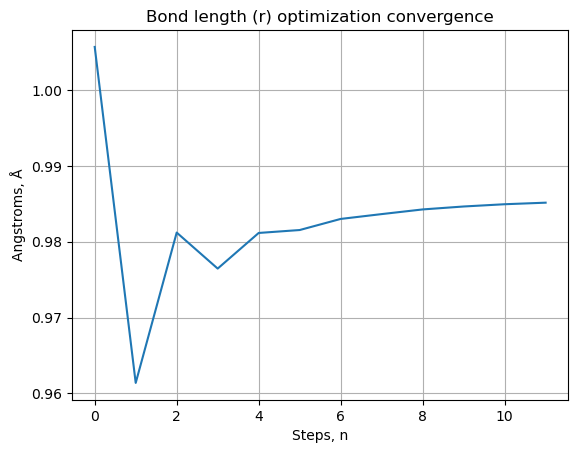

In [15]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
np_en = np.array(energy)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

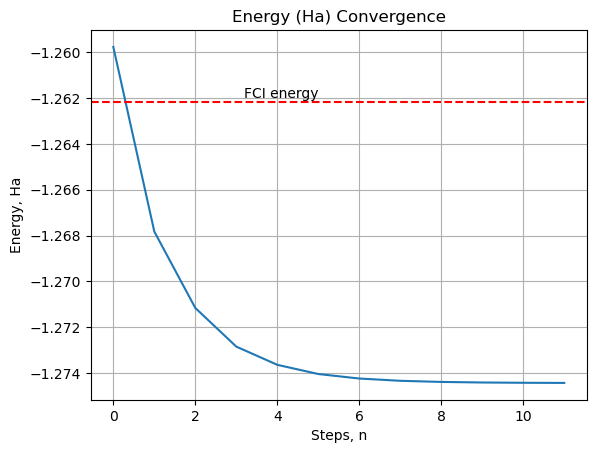

In [26]:
plt.plot(np_en)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")

plt.axhline(y=-1.2621759210848382, color='r', linestyle='--')
plt.text(5, -1.262, 'FCI energy', horizontalalignment='right')

plt.title("Energy (Ha) Convergence")
plt.grid(True)

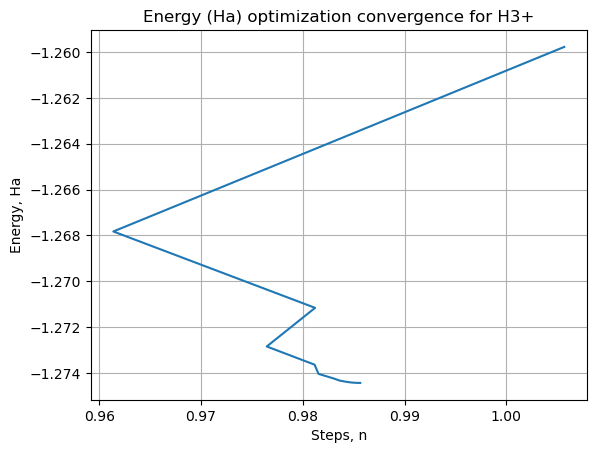

In [22]:
plt.plot(np_bl, np_en)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence for H3+")
plt.grid(True)

In [ ]:
np.array([0.7581    , 0.7581    , 0.7581    , 2.40445662, 1.04531947,
        1.1786185 , 1.33253895, 0.3375815 , 2.32749639], requires_grad=True)

In [32]:
geometry = np.array([[0.7581    , 0.7581    , 0.7581],
                     [2.40445662, 1.04531947, 1.1786185],
          [ 1.33253895, 0.3375815 , 2.32749639]], requires_grad=False)

In [34]:
H = qml.qchem.molecular_hamiltonian(symbols, geometry, charge=1)[0]
H_coeffs, H_ops = H.terms()
m = qml.resource.estimate_shots(H_coeffs)
print(f'Shots : {m:.2e}')

Shots : 6.41e+06
